# FoodVisionAI - Model Training

**Project:** Automated Nutritional Analysis Application  
**Module:** Data Analytics-3  
**Dataset:** Food-101 (101 food categories)  
**Architecture:** MobileNetV2 with Transfer Learning

---

## Table of Contents
1. Environment Configuration
2. Data Loading and Exploration
3. Data Preprocessing Pipeline
4. Model Architecture
5. Training Phase 1: Feature Extraction
6. Training Phase 2: Fine-tuning
7. Model Evaluation
8. Model Export
9. Inference Testing

## 1. Environment Configuration

Setting up environment variables and importing required libraries. The environment variables at the top help prevent threading issues that can cause mutex errors on macOS.

In [2]:
# IMPORTANT: These must be set BEFORE importing tensorflow
# This prevents the mutex lock error on macOS
import os

# Disable threading optimizations that can cause mutex issues
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['OBJC_DISABLE_INITIALIZE_FORK_SAFETY'] = 'YES'

# For macOS: Prevent OpenMP conflicts
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

# Limit TensorFlow to use single thread for operations (prevents mutex issues)
os.environ['TF_NUM_INTEROP_THREADS'] = '1'
os.environ['TF_NUM_INTRAOP_THREADS'] = '1'

In [3]:
import json
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Verify TensorFlow installation
print(f"TensorFlow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

/Users/samuelhanokanchan/Desktop/NutriFact/NutriFact/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/samuelhanokanchan/Desktop/NutriFact/NutriFact/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


TensorFlow Version: 2.17.1
Keras Version: 3.10.0
GPU Available: []


In [4]:
# Configuration
class Config:
    """Central configuration for the training pipeline."""
    
    # Data parameters
    IMAGE_SIZE = 224
    BATCH_SIZE = 32
    TRAIN_SPLIT = 0.8
    
    # Training parameters
    PHASE1_EPOCHS = 5
    PHASE2_EPOCHS = 5
    PHASE1_LR = 1e-3
    PHASE2_LR = 1e-4
    
    # Fine-tuning parameters
    UNFREEZE_LAYERS = 50
    
    # Paths
    MODEL_DIR = '../models'
    OUTPUT_DIR = '../outputs'
    
config = Config()

# Create directories
os.makedirs(config.MODEL_DIR, exist_ok=True)
os.makedirs(config.OUTPUT_DIR, exist_ok=True)

print("Configuration loaded.")

Configuration loaded.


## 2. Data Loading and Exploration

Loading the Food-101 dataset from TensorFlow Datasets. This dataset contains 101 food categories with 1000 images each.

In [5]:
print("Loading Food-101 dataset...")
print("This may take a few minutes on first run.\n")

# Load dataset with train/validation split
(train_ds_raw, val_ds_raw), dataset_info = tfds.load(
    'food101',
    split=[f'train[:{int(config.TRAIN_SPLIT * 100)}%]', 
           f'train[{int(config.TRAIN_SPLIT * 100)}%:]'],
    with_info=True,
    as_supervised=True
)

# Extract class information
class_names = dataset_info.features['label'].names
num_classes = len(class_names)

# Calculate dataset sizes
total_samples = dataset_info.splits['train'].num_examples
train_samples = int(total_samples * config.TRAIN_SPLIT)
val_samples = total_samples - train_samples

print("Dataset Information")
print("=" * 40)
print(f"Total Classes: {num_classes}")
print(f"Training Samples: {train_samples:,}")
print(f"Validation Samples: {val_samples:,}")
print(f"Image Shape: Variable (will resize to {config.IMAGE_SIZE}x{config.IMAGE_SIZE})")

Loading Food-101 dataset...
This may take a few minutes on first run.

Dataset Information
Total Classes: 101
Training Samples: 60,600
Validation Samples: 15,150
Image Shape: Variable (will resize to 224x224)


In [6]:
# Display sample classes
print("\nSample Food Categories:")
print("-" * 40)
for i in range(0, min(20, num_classes), 2):
    col1 = f"{i+1:3d}. {class_names[i]}"
    col2 = f"{i+2:3d}. {class_names[i+1]}" if i+1 < num_classes else ""
    print(f"{col1:30s} {col2}")


Sample Food Categories:
----------------------------------------
  1. apple_pie                   2. baby_back_ribs
  3. baklava                     4. beef_carpaccio
  5. beef_tartare                6. beet_salad
  7. beignets                    8. bibimbap
  9. bread_pudding              10. breakfast_burrito
 11. bruschetta                 12. caesar_salad
 13. cannoli                    14. caprese_salad
 15. carrot_cake                16. ceviche
 17. cheesecake                 18. cheese_plate
 19. chicken_curry              20. chicken_quesadilla


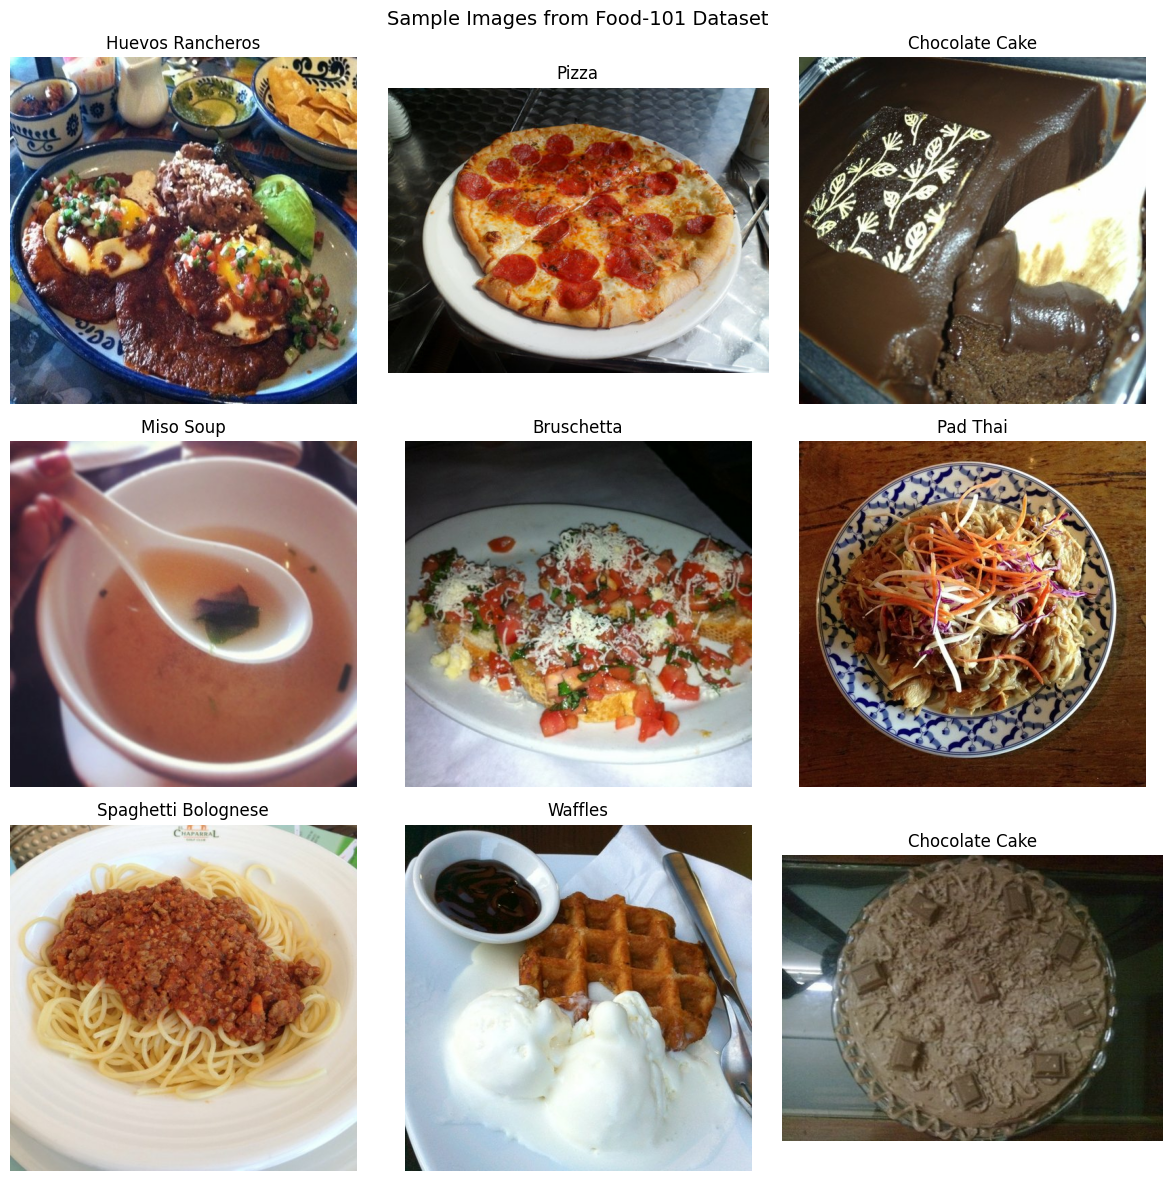

In [7]:
# Visualize sample images
def visualize_samples(dataset, class_names, num_samples=9):
    """Display a grid of sample images from the dataset."""
    plt.figure(figsize=(12, 12))
    
    for i, (image, label) in enumerate(dataset.take(num_samples)):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image.numpy())
        plt.title(class_names[label.numpy()].replace('_', ' ').title())
        plt.axis('off')
    
    plt.suptitle('Sample Images from Food-101 Dataset', fontsize=14)
    plt.tight_layout()
    plt.show()

visualize_samples(train_ds_raw, class_names)

## 3. Data Preprocessing Pipeline

Creating efficient data pipelines with preprocessing and augmentation.

In [11]:
def preprocess_image(image, label):
    """
    Preprocess a single image.
    - Resize to target dimensions
    - Normalize pixel values to [0, 1]
    """
    image = tf.image.resize(image, (config.IMAGE_SIZE, config.IMAGE_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label


def augment_image(image, label):
    """
    Apply data augmentation to increase training variety.
    """
    # First convert to float
    image = tf.cast(image, tf.float32)
    
    # Resize
    image = tf.image.resize(image, (config.IMAGE_SIZE, config.IMAGE_SIZE))
    
    # Normalize to [0, 1]
    image = image / 255.0
    
    # Random horizontal flip
    image = tf.image.random_flip_left_right(image)
    
    # Random brightness adjustment
    image = tf.image.random_brightness(image, max_delta=0.2)
    
    # Random contrast adjustment
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    
    # Random saturation adjustment
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    
    # Ensure values are still in valid range
    image = tf.clip_by_value(image, 0.0, 1.0)
    
    return image, label


def create_dataset_pipeline(dataset, is_training=True):
    """
    Create an optimized tf.data pipeline.
    """
    AUTOTUNE = tf.data.AUTOTUNE
    
    if is_training:
        dataset = dataset.shuffle(buffer_size=1000)
        dataset = dataset.map(augment_image, num_parallel_calls=AUTOTUNE)
    else:
        dataset = dataset.map(preprocess_image, num_parallel_calls=AUTOTUNE)
    
    dataset = dataset.batch(config.BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    
    return dataset

In [12]:
# Create training and validation pipelines
train_ds = create_dataset_pipeline(train_ds_raw, is_training=True)
val_ds = create_dataset_pipeline(val_ds_raw, is_training=False)


# Verify pipeline
for images, labels in train_ds.take(1):
    print(f"Batch shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Image value range: [{images.numpy().min():.3f}, {images.numpy().max():.3f}]")

print("\nData pipelines created successfully.")

Batch shape: (32, 224, 224, 3)
Labels shape: (32,)
Image value range: [0.000, 1.000]

Data pipelines created successfully.


## 4. Model Architecture

Building the model using MobileNetV2 as the base with custom classification layers.

In [13]:
def build_model(num_classes, image_size=224):
    """
    Build a transfer learning model using MobileNetV2.
    
    Architecture:
    - MobileNetV2 base (pretrained on ImageNet)
    - Global Average Pooling
    - Dense layers with dropout for regularization
    - Softmax output layer
    """
    
    # Load pretrained MobileNetV2
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(image_size, image_size, 3),
        include_top=False,
        weights='imagenet'
    )
    
    # Freeze base model initially
    base_model.trainable = False
    
    # Build the complete model
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model, base_model

In [14]:
# Build the model
print("Building model architecture...")
model, base_model = build_model(num_classes, config.IMAGE_SIZE)

# Display model summary
print(f"\nModel Summary")
print("=" * 50)
print(f"Base Model: MobileNetV2")
print(f"Total Parameters: {model.count_params():,}")
print(f"Trainable Parameters: {sum([tf.keras.backend.count_params(w) for w in model.trainable_weights]):,}")
print(f"Non-trainable Parameters: {sum([tf.keras.backend.count_params(w) for w in model.non_trainable_weights]):,}")
print(f"Output Classes: {num_classes}")

Building model architecture...

Model Summary
Base Model: MobileNetV2
Total Parameters: 3,076,261
Trainable Parameters: 815,717
Non-trainable Parameters: 2,260,544
Output Classes: 101


In [15]:
# Optional: View detailed model architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 101)            │        25,957 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,076,261 (11.74 MB)

 Trainable params: 815,717 (3.11 MB)

 Non-trainable params: 2,260,544 (8.62 MB)

## 5. Training Phase 1: Feature Extraction

Training only the custom classification layers while keeping the base model frozen.

In [16]:
# Compile model for Phase 1
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=config.PHASE1_LR),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
callbacks_phase1 = [
    EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-6,
        verbose=1
    )
]

print("Model compiled for Phase 1 training.")

Model compiled for Phase 1 training.


In [17]:
print("\n" + "=" * 60)
print("PHASE 1: Feature Extraction (Frozen Base)")
print("=" * 60 + "\n")

history_phase1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=config.PHASE1_EPOCHS,
    callbacks=callbacks_phase1,
    verbose=1
)


PHASE 1: Feature Extraction (Frozen Base)

Epoch 1/5
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 1080s 570ms/step - accuracy: 0.2507 - loss: 3.2594 - val_accuracy: 0.4785 - val_loss: 2.1060 - learning_rate: 0.0010
Epoch 2/5
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 1106s 584ms/step - accuracy: 0.4104 - loss: 2.3856 - val_accuracy: 0.5030 - val_loss: 1.9917 - learning_rate: 0.0010
Epoch 3/5
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 1167s 616ms/step - accuracy: 0.4488 - loss: 2.2099 - val_accuracy: 0.5092 - val_loss: 1.9582 - learning_rate: 0.0010
Epoch 4/5
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 1141s 602ms/step - accuracy: 0.4674 - loss: 2.1184 - val_accuracy: 0.5166 - val_loss: 1.9412 - learning_rate: 0.0010
Epoch 5/5
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 1173s 619ms/step - accuracy: 0.4876 - loss: 2.0405 - val_accuracy: 0.5253 - val_loss: 1.9191 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 5.


In [18]:
# Evaluate Phase 1
loss_p1, acc_p1 = model.evaluate(val_ds, verbose=0)
print(f"\nPhase 1 Results:")
print(f"  Validation Loss: {loss_p1:.4f}")
print(f"  Validation Accuracy: {acc_p1:.4f} ({acc_p1*100:.2f}%)")


Phase 1 Results:
  Validation Loss: 1.9191
  Validation Accuracy: 0.5253 (52.53%)


## 6. Training Phase 2: Fine-tuning

Unfreezing the top layers of the base model and training with a lower learning rate.

In [19]:
# Unfreeze the top layers of the base model
base_model.trainable = True

# Freeze all layers except the last N
for layer in base_model.layers[:-config.UNFREEZE_LAYERS]:
    layer.trainable = False

# Count trainable parameters after unfreezing
trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
print(f"Trainable parameters after unfreezing: {trainable_params:,}")

Trainable parameters after unfreezing: 2,670,821


In [20]:
# Recompile with lower learning rate
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=config.PHASE2_LR),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks for Phase 2
callbacks_phase2 = [
    EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=os.path.join(config.MODEL_DIR, 'food_model_best.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("Model recompiled for Phase 2 fine-tuning.")

Model recompiled for Phase 2 fine-tuning.


In [21]:
print("\n" + "=" * 60)
print("PHASE 2: Fine-tuning (Partial Base Unfrozen)")
print("=" * 60 + "\n")

history_phase2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=config.PHASE2_EPOCHS,
    callbacks=callbacks_phase2,
    verbose=1
)


PHASE 2: Fine-tuning (Partial Base Unfrozen)

Epoch 1/5
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 0s 784ms/step - accuracy: 0.4463 - loss: 2.2753
Epoch 1: val_accuracy improved from -inf to 0.53261, saving model to ../models/food_model_best.keras
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 1716s 904ms/step - accuracy: 0.4463 - loss: 2.2752 - val_accuracy: 0.5326 - val_loss: 1.9106
Epoch 2/5
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 0s 983ms/step - accuracy: 0.5563 - loss: 1.7570
Epoch 2: val_accuracy improved from 0.53261 to 0.57485, saving model to ../models/food_model_best.keras
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 2103s 1s/step - accuracy: 0.5563 - loss: 1.7569 - val_accuracy: 0.5749 - val_loss: 1.7251
Epoch 3/5
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 0s 874ms/step - accuracy: 0.6044 - loss: 1.5323
Epoch 3: val_accuracy improved from 0.57485 to 0.59789, saving model to ../models/food_model_best.keras
1894/1894 ━━━━━━━━━━━━━━━━━━━━ 1913s 1s/step - accuracy: 0.6044 - loss: 1.5323 - val_accuracy: 0.5979 - val_loss: 1.6353
Epoch 4/5
1

In [22]:
# Evaluate Phase 2
loss_p2, acc_p2 = model.evaluate(val_ds, verbose=0)
print(f"\nPhase 2 Results:")
print(f"  Validation Loss: {loss_p2:.4f}")
print(f"  Validation Accuracy: {acc_p2:.4f} ({acc_p2*100:.2f}%)")
print(f"  Improvement from Phase 1: {(acc_p2-acc_p1)*100:+.2f}%")


Phase 2 Results:
  Validation Loss: 1.5650
  Validation Accuracy: 0.6221 (62.21%)
  Improvement from Phase 1: +9.68%


## 7. Model Evaluation

Detailed evaluation with confusion matrix and classification metrics.

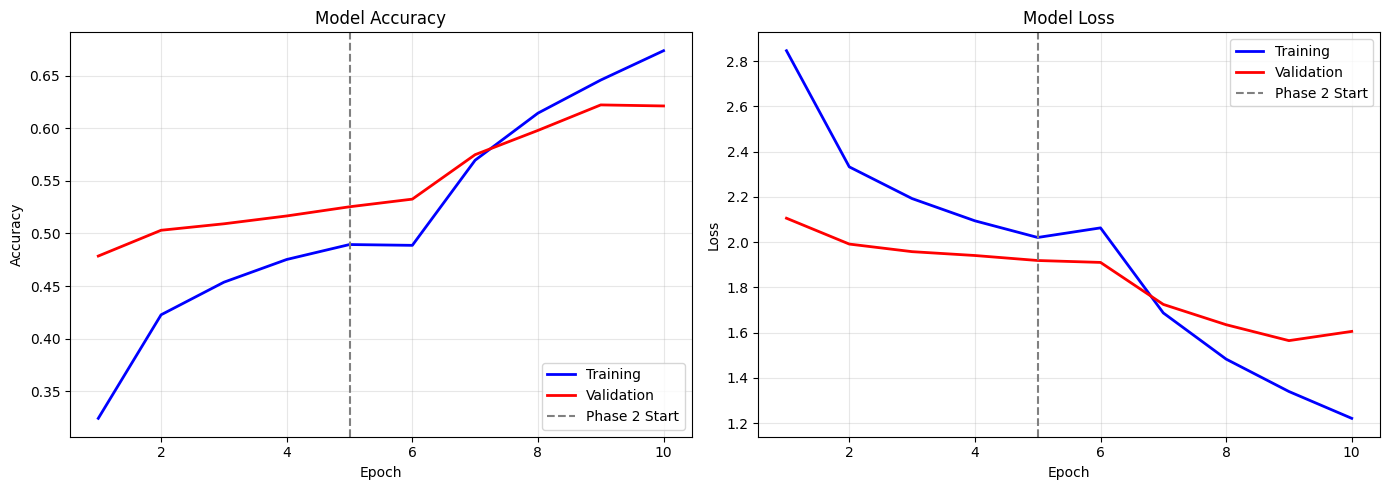


Plot saved to: ../outputs/training_history.png


In [23]:
def plot_training_history(history1, history2):
    """
    Plot training and validation metrics across both phases.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Combine histories
    acc = history1.history['accuracy'] + history2.history['accuracy']
    val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
    loss = history1.history['loss'] + history2.history['loss']
    val_loss = history1.history['val_loss'] + history2.history['val_loss']
    
    epochs = range(1, len(acc) + 1)
    phase1_end = len(history1.history['accuracy'])
    
    # Accuracy plot
    axes[0].plot(epochs, acc, 'b-', label='Training', linewidth=2)
    axes[0].plot(epochs, val_acc, 'r-', label='Validation', linewidth=2)
    axes[0].axvline(x=phase1_end, color='gray', linestyle='--', label='Phase 2 Start')
    axes[0].set_title('Model Accuracy', fontsize=12)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend(loc='lower right')
    axes[0].grid(True, alpha=0.3)
    
    # Loss plot
    axes[1].plot(epochs, loss, 'b-', label='Training', linewidth=2)
    axes[1].plot(epochs, val_loss, 'r-', label='Validation', linewidth=2)
    axes[1].axvline(x=phase1_end, color='gray', linestyle='--', label='Phase 2 Start')
    axes[1].set_title('Model Loss', fontsize=12)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend(loc='upper right')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(config.OUTPUT_DIR, 'training_history.png'), dpi=150, bbox_inches='tight')
    plt.show()
    print(f"\nPlot saved to: {config.OUTPUT_DIR}/training_history.png")

plot_training_history(history_phase1, history_phase2)

In [24]:
def evaluate_model_detailed(model, dataset, class_names, num_batches=50):
    """
    Perform detailed model evaluation.
    """
    y_true = []
    y_pred = []
    
    print("Generating predictions...")
    for images, labels in dataset.take(num_batches):
        predictions = model.predict(images, verbose=0)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(predictions, axis=1))
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate accuracy
    accuracy = np.mean(y_true == y_pred)
    print(f"\nOverall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    
    return y_true, y_pred

y_true, y_pred = evaluate_model_detailed(model, val_ds, class_names)

Generating predictions...

Overall Accuracy: 0.6219 (62.19%)


In [25]:
# Print classification report for top classes
print("\nClassification Report (Sample):")
print("=" * 60)

# Get unique classes in predictions
unique_classes = np.unique(np.concatenate([y_true, y_pred]))
target_names = [class_names[i] for i in unique_classes[:20]]  # First 20 classes

# Filter to only those classes
mask = np.isin(y_true, unique_classes[:20]) & np.isin(y_pred, unique_classes[:20])
if mask.sum() > 0:
    report = classification_report(
        y_true[mask], 
        y_pred[mask], 
        labels=unique_classes[:20],
        target_names=target_names,
        zero_division=0
    )
    print(report)


Classification Report (Sample):
                    precision    recall  f1-score   support

         apple_pie       0.20      0.25      0.22         4
    baby_back_ribs       1.00      0.80      0.89        10
           baklava       0.73      0.67      0.70        12
    beef_carpaccio       0.83      0.83      0.83        12
      beef_tartare       1.00      0.88      0.93         8
        beet_salad       0.89      0.89      0.89         9
          beignets       0.91      0.91      0.91        11
          bibimbap       1.00      1.00      1.00        11
     bread_pudding       0.33      0.75      0.46         4
 breakfast_burrito       0.80      0.73      0.76        11
        bruschetta       0.89      0.73      0.80        11
      caesar_salad       0.82      1.00      0.90         9
           cannoli       0.91      0.77      0.83        13
     caprese_salad       0.67      1.00      0.80         8
       carrot_cake       1.00      0.88      0.94        17
      

## 8. Model Export

Saving the model in native Keras format (recommended over pickle).

In [26]:
# Define paths
MODEL_PATH = os.path.join(config.MODEL_DIR, 'food_classifier.keras')
CLASSES_PATH = os.path.join(config.MODEL_DIR, 'food_classes.json')
CONFIG_PATH = os.path.join(config.MODEL_DIR, 'model_config.json')

# Save the model in native Keras format
print("Saving model...")
model.save(MODEL_PATH)
print(f"  Model saved: {MODEL_PATH}")

# Save class names
with open(CLASSES_PATH, 'w') as f:
    json.dump(class_names, f, indent=2)
print(f"  Classes saved: {CLASSES_PATH}")

# Save model configuration
model_config = {
    'image_size': config.IMAGE_SIZE,
    'num_classes': num_classes,
    'class_names': class_names,
    'model_architecture': 'MobileNetV2',
    'final_accuracy': float(acc_p2),
    'training_phases': {
        'phase1_epochs': len(history_phase1.history['accuracy']),
        'phase2_epochs': len(history_phase2.history['accuracy']),
        'phase1_accuracy': float(acc_p1),
        'phase2_accuracy': float(acc_p2)
    }
}

with open(CONFIG_PATH, 'w') as f:
    json.dump(model_config, f, indent=2)
print(f"  Config saved: {CONFIG_PATH}")

print("\nModel export complete.")

Saving model...
  Model saved: ../models/food_classifier.keras
  Classes saved: ../models/food_classes.json
  Config saved: ../models/model_config.json

Model export complete.


## 9. Inference Testing

Testing the saved model to ensure it loads and predicts correctly.

In [27]:
# Load the saved model
print("Loading saved model...")
loaded_model = keras.models.load_model(MODEL_PATH)

# Load class names
with open(CLASSES_PATH, 'r') as f:
    loaded_class_names = json.load(f)

print(f"Model loaded successfully.")
print(f"Classes loaded: {len(loaded_class_names)}")

Loading saved model...
Model loaded successfully.
Classes loaded: 101


In [28]:
def predict_food(model, image, class_names, top_k=5):
    """
    Make prediction on a single image.
    
    Args:
        model: Loaded Keras model
        image: Preprocessed image tensor
        class_names: List of class names
        top_k: Number of top predictions to return
    
    Returns:
        List of (class_name, confidence) tuples
    """
    # Ensure batch dimension
    if len(image.shape) == 3:
        image = tf.expand_dims(image, 0)
    
    # Get predictions
    predictions = model.predict(image, verbose=0)[0]
    
    # Get top-k predictions
    top_indices = np.argsort(predictions)[-top_k:][::-1]
    
    results = []
    for idx in top_indices:
        results.append({
            'class': class_names[idx],
            'confidence': float(predictions[idx])
        })
    
    return results

In [29]:
# Test on validation samples
print("Testing model on validation samples:\n")
print("=" * 70)

correct = 0
total = 0

for images, labels in val_ds.take(3):
    for img, label in zip(images[:5], labels[:5]):
        results = predict_food(loaded_model, img, loaded_class_names, top_k=1)
        
        true_class = loaded_class_names[label.numpy()]
        pred_class = results[0]['class']
        confidence = results[0]['confidence']
        
        is_correct = true_class == pred_class
        if is_correct:
            correct += 1
        total += 1
        
        status = "CORRECT" if is_correct else "WRONG"
        print(f"[{status:7s}] True: {true_class:25s} | Pred: {pred_class:25s} | {confidence:.2%}")

print("=" * 70)
print(f"\nTest Accuracy: {correct/total*100:.1f}% ({correct}/{total})")

Testing model on validation samples:

[CORRECT] True: spaghetti_carbonara       | Pred: spaghetti_carbonara       | 96.17%
[CORRECT] True: clam_chowder              | Pred: clam_chowder              | 95.98%
[WRONG  ] True: chicken_curry             | Pred: paella                    | 22.28%
[WRONG  ] True: ravioli                   | Pred: caprese_salad             | 49.01%
[CORRECT] True: lasagna                   | Pred: lasagna                   | 61.41%
[WRONG  ] True: pancakes                  | Pred: hamburger                 | 16.72%
[WRONG  ] True: grilled_salmon            | Pred: caesar_salad              | 86.37%
[CORRECT] True: cheese_plate              | Pred: cheese_plate              | 99.96%
[WRONG  ] True: sushi                     | Pred: greek_salad               | 49.29%
[WRONG  ] True: macarons                  | Pred: macaroni_and_cheese       | 45.86%
[CORRECT] True: churros                   | Pred: churros                   | 99.89%
[CORRECT] True: clam_chowde

## Summary

Training complete. The following files have been saved:

In [30]:
print("\n" + "=" * 70)
print("TRAINING COMPLETE")
print("=" * 70)

print(f"\nDataset: Food-101 ({num_classes} classes)")
print(f"Architecture: MobileNetV2 + Custom Classification Head")
print(f"Final Validation Accuracy: {acc_p2:.4f} ({acc_p2*100:.2f}%)")

print(f"\nSaved Files:")
print(f"  1. {MODEL_PATH}")
print(f"  2. {CLASSES_PATH}")
print(f"  3. {CONFIG_PATH}")
print(f"  4. {config.OUTPUT_DIR}/training_history.png")

print(f"\nUsage Example:")
print("  from tensorflow import keras")
print("  import json")
print("  ")
print("  model = keras.models.load_model('models/food_classifier.keras')")
print("  with open('models/food_classes.json') as f:")
print("      classes = json.load(f)")
print("  ")
print("  # Preprocess your image and predict")
print("  predictions = model.predict(preprocessed_image)")

print("\n" + "=" * 70)


TRAINING COMPLETE

Dataset: Food-101 (101 classes)
Architecture: MobileNetV2 + Custom Classification Head
Final Validation Accuracy: 0.6221 (62.21%)

Saved Files:
  1. ../models/food_classifier.keras
  2. ../models/food_classes.json
  3. ../models/model_config.json
  4. ../outputs/training_history.png

Usage Example:
  from tensorflow import keras
  import json
  
  model = keras.models.load_model('models/food_classifier.keras')
  with open('models/food_classes.json') as f:
      classes = json.load(f)
  
  # Preprocess your image and predict
  predictions = model.predict(preprocessed_image)

